In [1]:
%load_ext blackcellmagic
%load_ext notexbook

%texify

# Model Inversion Attack

In this notebook we will be performing the **Model Inversion Attack** considering two pre-trained ML models as originally described in the reference paper:

> **Model Inversion Attacks that Exploit Confidence Information and Basic Countermeasures**, by _Fredrikson, et. al_, 2015 
[DOI](https://dl.acm.org/doi/pdf/10.1145/2810103.2813677).

The two models are `SoftmaxRegression` and `MLP`.

⚠️ **Note**: All the experimental settings, and choices made in this notebook are _replicating_ exactly the original paper.

In [2]:
import torch as th
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

In [4]:
from pathlib import Path
import os

DATA_FOLDER = Path(os.path.join(os.path.abspath(os.path.curdir), "..", "..")) / "data"

In [5]:
from dataset import ORLFaces
from torchvision.transforms import ToTensor

In [6]:
orl_faces_train = ORLFaces(root=DATA_FOLDER, download=True, split="train", transform=ToTensor())
orl_faces_test = ORLFaces(root=DATA_FOLDER, download=True, split="test", transform=ToTensor())

In [7]:
orl_faces_train.data.shape, orl_faces_test.data.shape

(torch.Size([280, 112, 92]), torch.Size([120, 112, 92]))

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(orl_faces_train, batch_size=32, shuffle=False, drop_last=False)

## Reconstruction Attack

#### Settings

In [9]:
# Reconstruction Attack Settings
# See Paper, Section 5.2 - Reconstruction Attack
α = 5000  # total iterations
β = 100   # max nr. of iterations without improvements
γ = 0.99  # threshold of the cost 
λ = 0.1   # learning rate

#### Load Pre-trained Models

In [10]:
from models import SoftmaxRegression

⚠️ Grab the **pre-trained** weights of the `SoftmaxRegression` model here: [softmax_regression_mia.pt](https://www.dropbox.com/s/t9wglqyj5zr74fq/softmax_mia.pt?dl=1) and save it into the local `checkpoints` folder



In [11]:
from pathlib import Path 

CHECKPOINT_FOLDER = Path("./checkpoints/")
CHECKPOINT_FOLDER.mkdir(exist_ok=True)

def load_weights(model, model_filename: str = None):
    if model_filename is None or not model_filename:
        model_filename = f"{model.__class__.__name__.lower()}.pt"
    w_file = CHECKPOINT_FOLDER / model_filename
    try:
        weights = th.load(open(w_file, "rb"))
    except FileNotFoundError: 
        print(f"Model Weights file {w_file} does not exist! Please check.")
        return None
    return weights


In [12]:
softmax_reg = SoftmaxRegression()
weights = load_weights(softmax_reg, model_filename="softmax_mia.pt")
if weights is not None:
    softmax_reg.load_state_dict(weights)
    
softmax_reg

SoftmaxRegression(
  (regression): Linear(in_features=10304, out_features=40, bias=True)
)

## MIA Reconstruction Strategy


<img src="./mia_reconstruction.png" alt="MIA Reconstruction Attack" class="maxw50" />

In [13]:
def process(im_flatten):
    max_v = th.max(im_flatten)
    min_v = th.min(im_flatten)
    return (im_flatten-min_v) / (max_v - min_v)

In [14]:
def mi_face(model, target_label):
    aim_tensor = th.zeros(1, 112*92)
    aim_tensor.requires_grad = True
    
    lossn_1 = 10
    b = 0
    g = 0
    
    out = model(aim_tensor.detach())
    _, pred = th.max(out, 1)
    print(pred)
    print(f'original input image {target_label}')
    plt.imshow(np.transpose(aim_tensor.detach().reshape(1, 112, 92).numpy(), (1, 2, 0)), cmap="Greys")
    plt.show()
    print(f'original input image predict label {target_label} - predict label: {pred.item()}')
    
    criterion = th.nn.NLLLoss()
    
    for i in range(α):
        out = model(aim_tensor)
        if aim_tensor.grad is not None:
            aim_tensor.grad.zero_()
        out = out.reshape(1, 40)
        target_class = th.tensor([target_label])
        loss = criterion(out, target_class)
        loss.backward()
        aim_grad = aim_tensor.grad
        
        # SGD Step
        # see https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
        aim_tensor = aim_tensor - (λ * aim_grad)
        aim_tensor = process(aim_tensor)
        aim_tensor = th.clamp(aim_tensor.detach(), 0, 1)
        aim_tensor.requires_grad = True
        if loss >= lossn_1:
            b += 1
            if b > β:
                break
        else:
            b = 0
        lossn_1 = loss
        if loss < γ:
            break
    
    print(f"Attack completed at {i} iterations")
    out = model(aim_tensor.detach())
    _, pred = th.max(out, 1)
    print(pred)
    print(f'inverted image {target_label}')
    plt.imshow(np.transpose(aim_tensor.detach().reshape(1, 112, 92).numpy() * 255, (1, 2, 0)), cmap="Greys")
    plt.show()

    

tensor([38])
original input image 0


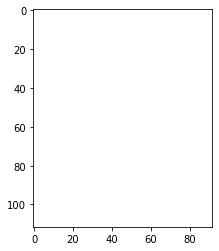

original input image predict label 0 - predict label: 38
Attack completed at 1 iterations
tensor([0])
inverted image 0


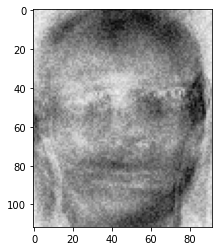

tensor([38])
original input image 1


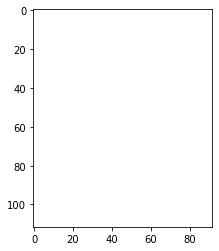

original input image predict label 1 - predict label: 38
Attack completed at 1 iterations
tensor([1])
inverted image 1


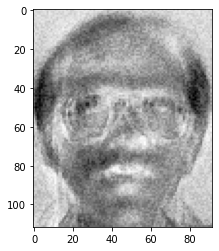

tensor([38])
original input image 2


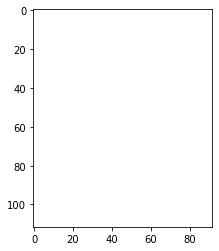

original input image predict label 2 - predict label: 38
Attack completed at 1 iterations
tensor([2])
inverted image 2


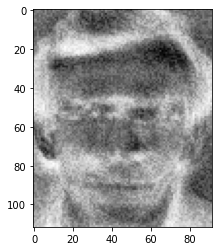

tensor([38])
original input image 3


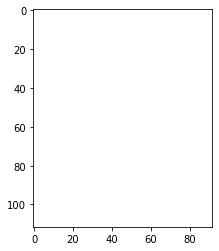

original input image predict label 3 - predict label: 38
Attack completed at 1 iterations
tensor([3])
inverted image 3


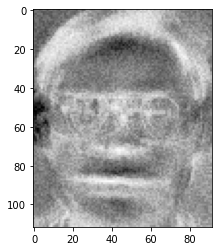

tensor([38])
original input image 4


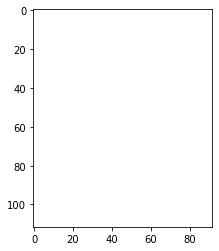

original input image predict label 4 - predict label: 38
Attack completed at 1 iterations
tensor([4])
inverted image 4


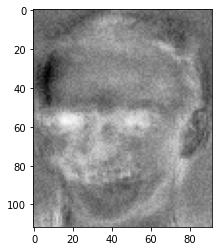

tensor([38])
original input image 5


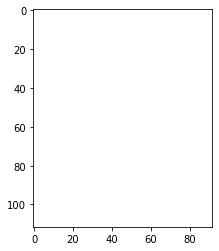

original input image predict label 5 - predict label: 38
Attack completed at 1 iterations
tensor([5])
inverted image 5


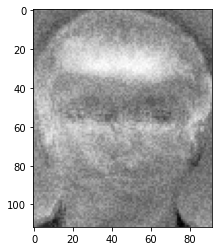

tensor([38])
original input image 6


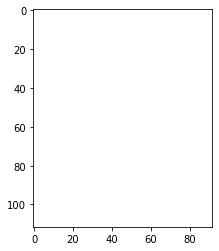

original input image predict label 6 - predict label: 38
Attack completed at 1 iterations
tensor([6])
inverted image 6


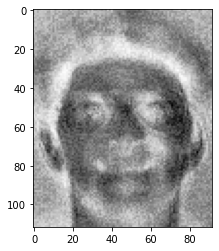

tensor([38])
original input image 7


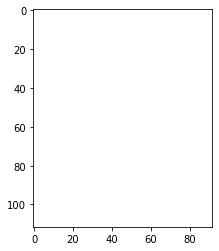

original input image predict label 7 - predict label: 38
Attack completed at 1 iterations
tensor([7])
inverted image 7


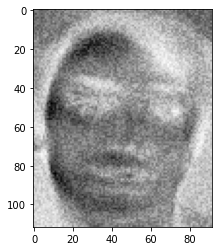

tensor([38])
original input image 8


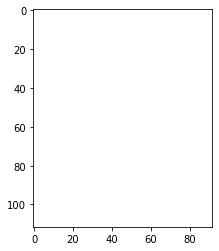

original input image predict label 8 - predict label: 38
Attack completed at 1 iterations
tensor([8])
inverted image 8


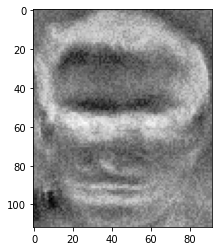

tensor([38])
original input image 9


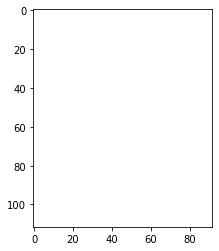

original input image predict label 9 - predict label: 38
Attack completed at 1 iterations
tensor([9])
inverted image 9


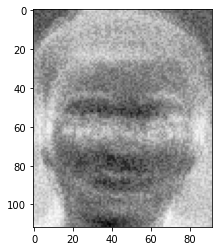

In [15]:
# Let's try to reconstruct the data for the first 10 classes (i.e. faces)
for cl in range(10):
    mi_face(softmax_reg, cl)

### Exercise: 

Write the code to try the **model inversion reconstruction** using the `MLP` model

In [ ]:
from models import MLP

⚠️ Grab the **pre-trained** weights of the `SoftmaxRegression` model here: [mlp_mia.pt](https://www.dropbox.com/s/8ul2lj2eqcykfxm/mlp_mia.pt?dl=1) and save it into the local `checkpoints` folder

In [ ]:
mlp = MLP()
weights = # Please complete HERE
    
mlp

In [ ]:
# Reconstruction Attack code HERE
for cl in range(10):
    mi_face(mlp, cl)